In [1]:
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
from simple_tritium_transport_model import Model, ureg, quantity_to_activity

In [2]:
ureg.define("T = 1 * particle")
ureg.define("n = 1 * particle")

baby_diameter = 5.512 * ureg.inches # from CAD drawings
baby_radius = baby_diameter/2
baby_volume = 1 * ureg.L
baby_cross_section = np.pi * baby_radius**2
baby_height = baby_volume/baby_cross_section
print(baby_height.to(ureg.cm))
print((baby_cross_section * baby_height)   .to(ureg.L))
baby_model = Model(
    radius=baby_radius,
    height=baby_height,
    TBR=3.5e-3 * ureg.T * ureg.n**-1,
)

mass_transport_coeff_factor = 3

baby_model.k_top *= mass_transport_coeff_factor
baby_model.k_wall *= mass_transport_coeff_factor

6.495674700870306 centimeter
1.0 liter


(0.0, 7.145242170957337)

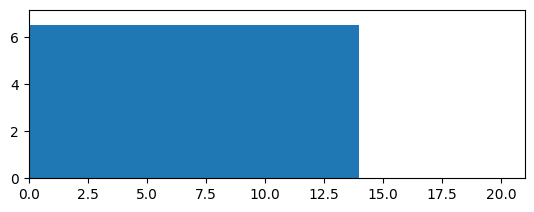

In [3]:
from matplotlib.patches import Rectangle

plt.gca().add_patch(Rectangle((0, 0), (baby_model.radius * 2).to(ureg.cm).magnitude, baby_model.height.to(ureg.cm).magnitude))
plt.gca().set_aspect('equal')
plt.xlim(0, baby_model.radius.to(ureg.cm).magnitude * 3)
plt.ylim(0, baby_model.height.to(ureg.cm).magnitude * 1.1)

In [4]:
baby_model.exposure_time = 4 * ureg.hour
resting_time = 0.5 * ureg.hour
cycle_time = baby_model.exposure_time + resting_time
irradiations = []
for day in range(2):
    irradiations.append([day * ureg.day, day * ureg.day + baby_model.exposure_time])
    while irradiations[-1][-1] + cycle_time < day * ureg.day + 12 * ureg.hour:
        irradiation_start = irradiations[-1][-1] + resting_time
        irradiation_stop = irradiation_start + baby_model.exposure_time
        irradiations.append([irradiation_start, irradiation_stop])
baby_model.irradiations = irradiations

baby_model.dt = baby_model.exposure_time/10
print(f"Salt volume: {baby_model.volume.to(ureg.L):.2f~P}")
print(f"TBR: {baby_model.TBR.to(ureg.dimensionless):.4f~P}")

baby_model.number_days = 2 * ureg.days
baby_model.neutron_rate = 1.2e8 * ureg.neutron * ureg.s**-1
baby_model.run(t_final=9*ureg.day)

Salt volume: 1.00 l
TBR: 0.0035


/home/remidm/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:224: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x0 = asarray(x0).flatten()
/home/remidm/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:239: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
/home/remidm/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:448: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y)
/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:452: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x)


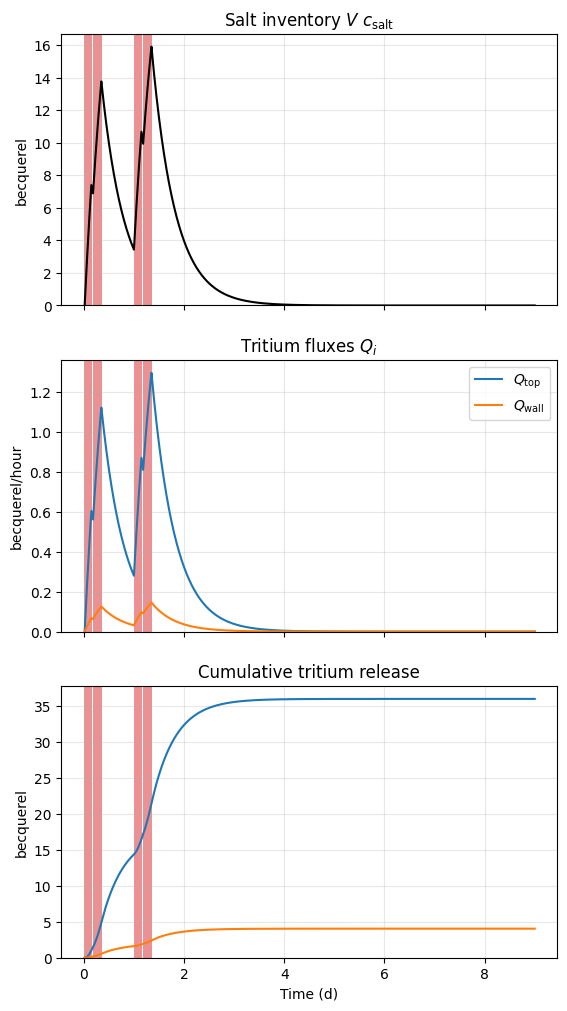

In [5]:
time = baby_model.times.to(ureg.day)

fig, (ax_inv, ax_fluxes, ax_cumul) = plt.subplots(3, 1, sharex=True, figsize=(6.4, 12))
plt.sca(ax_inv)
plt.title("Salt inventory $V \ c_\mathrm{salt}$")
plt.plot(
    time,
    quantity_to_activity(baby_model.concentrations * baby_model.volume).to(ureg.Bq),
    color="black",
)

plt.sca(ax_fluxes)
plt.title("Tritium fluxes $Q_i$")
release_top = quantity_to_activity(baby_model.Q_top(baby_model.concentrations)).to(
    ureg.Bq * ureg.s**-1
)
release_top = release_top.to(ureg.Bq * ureg.h**-1)
release_walls = quantity_to_activity(baby_model.Q_wall(baby_model.concentrations)).to(
    ureg.Bq * ureg.s**-1
)
release_walls = release_walls.to(ureg.Bq * ureg.h**-1)
plt.plot(time, release_top, label="$Q_\mathrm{top}$")
plt.plot(time, release_walls, label="$Q_\mathrm{wall}$")
plt.legend()

plt.sca(ax_cumul)
plt.title("Cumulative tritium release")
integrated_top = quantity_to_activity(baby_model.integrated_release_top()).to(ureg.Bq)
integrated_wall = quantity_to_activity(baby_model.integrated_release_wall()).to(ureg.Bq)

plt.plot(time, integrated_top, label="top")
plt.plot(time, integrated_wall, label="wall")
plt.xlabel(f"Time ({time.units:~P})")

for ax in [ax_inv, ax_fluxes, ax_cumul]:
    ax.set_ylim(bottom=0)
    ax.grid(alpha=0.3)
    for irr in baby_model.irradiations:
        ax.axvspan(
            irr[0].to(ureg.day),
            irr[1].to(ureg.day),
            facecolor="tab:red",
            alpha=0.5,
        )

plt.savefig("basic_model_results.pdf")
plt.show()

In [6]:
def replace_water(sample_activity, time, replacement_times=None):
    sample_activity_changed = np.copy(sample_activity)
    times_changed = np.copy(time)

    if replacement_times is None:
        replacement_times = [
            i + 1 for i in range(baby_model.number_days.to(ureg.day).magnitude)
        ] * ureg.day
    else:
        replacement_times = sorted(replacement_times)

    for replacement_time in replacement_times:
        indices = np.where(times_changed > replacement_time)
        # before each irradiation, make the sample activity drop to zero
        sample_activity_changed[indices] -= sample_activity_changed[indices][0]

        # insert nan value to induce a line break in plots
        if indices[0].size > 0:
            first_index = indices[0][0]
            sample_activity_changed = np.insert(
                sample_activity_changed, first_index, np.nan * ureg.Bq
            )
            times_changed = np.insert(times_changed, first_index, np.nan * ureg.day)

    return sample_activity_changed, times_changed

In [7]:
COLLECTION_VOLUME = 10 * ureg.ml
LSC_SAMPLE_VOLUME = 10 * ureg.ml

def plot_model(
    model,
    top=True,
    walls=True,
    detection_limit=0.4 * ureg.Bq,
    irradiation=True,
    replace_vials_top=True,
    replace_vials_walls=True,
    title=True,
    subtitle=True,
    linelabel=True,
):
    plt.gca().xaxis.set_units(ureg.day)
    plt.gca().yaxis.set_units(ureg.Bq)

    if title:
        plt.gcf().text(0.08, 0.97, "Sample activity", weight="bold", fontsize=15)
    if subtitle:
        print(model.exposure_time)
        subtitle_text = [
            f"TBR = {model.TBR.to(ureg.dimensionless):.2e~P}, salt volume {model.volume.to(ureg.ml):.0f~P}, neutron rate: {model.neutron_rate:.2e~P}, irradiation time: {model.exposure_time}",
            f"collection volume: {COLLECTION_VOLUME:.0f~P}, sample volume: {LSC_SAMPLE_VOLUME:.0f~P}",
        ]
        plt.gcf().text(0.08, 0.9, s="\n".join(subtitle_text), fontsize=6.5)

    if top:
        integrated_top = quantity_to_activity(model.integrated_release_top()).to(
            ureg.Bq
        )
        sample_activity_top = integrated_top / COLLECTION_VOLUME * LSC_SAMPLE_VOLUME
        times = model.times
        if replace_vials_top:
            if replace_vials_top is True:
                replacement_times = None
            else:
                replacement_times = replace_vials_top
            sample_activity_top, times = replace_water(
                sample_activity_top, model.times, replacement_times=replacement_times
            )
        plt.plot(
            times.to(ureg.day),
            sample_activity_top,
            color="tab:blue",
            label="Top",
        )
    if walls:
        integrated_wall = quantity_to_activity(model.integrated_release_wall()).to(
            ureg.Bq
        )
        sample_activity_wall = integrated_wall / COLLECTION_VOLUME * LSC_SAMPLE_VOLUME
        times = model.times
        if replace_vials_walls:
            if replace_vials_walls is True:
                replacement_times = None
            else:
                replacement_times = replace_vials_walls
            sample_activity_wall, times = replace_water(
                sample_activity_wall, model.times, replacement_times=replacement_times
            )
        plt.plot(
            times.to(ureg.day),
            sample_activity_wall,
            color="tab:orange",
            label="Walls",
        )

    if detection_limit:
        plt.axhline(y=detection_limit, color="tab:grey", linestyle="dashed")

    if irradiation:
        if irradiation is True:
            for day in range(model.number_days.to(ureg.day).magnitude):
                plt.axvspan(
                    0 * ureg.h + day * ureg.day,
                    model.exposure_time + day * ureg.day,
                    facecolor="tab:red",
                    alpha=0.5,
                )
        else:
            for irr in irradiation:
                plt.axvspan(
                    irr[0].to(ureg.day),
                    irr[1].to(ureg.day),
                    facecolor="tab:red",
                    alpha=0.5,
                )

    plt.xlim(left=0 * ureg.day)
    plt.ylim(bottom=0)
    # plt.yscale("log")
    if linelabel:
        labelLines(plt.gca().get_lines(), zorder=2.5)
    plt.gca().spines[["right", "top"]].set_visible(False)
    plt.grid(alpha=0.5)

4 hour


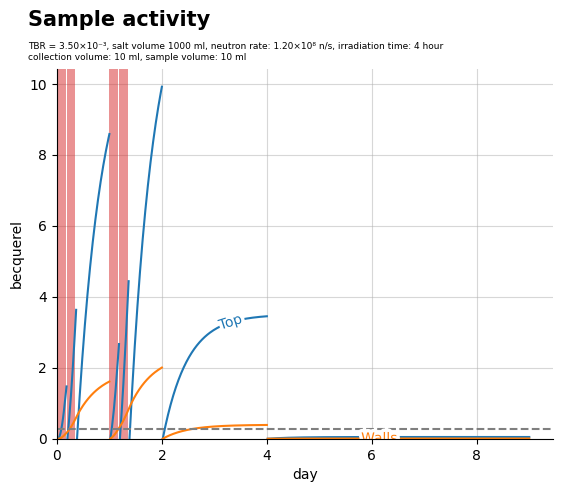

In [20]:
plt.figure()

replacement_times_top = [
    1 * cycle_time,
    2 * cycle_time,
    1 * ureg.day,
    1 * ureg.day + 1 * cycle_time,
    1 * ureg.day + 2 * cycle_time,
    2 * ureg.day,
    4 * ureg.day,
]

replacement_times_walls = [
    1 * ureg.day,
    2 * ureg.day,
    4 * ureg.day,

]

avg_background = 0.265 * ureg.Bq
plot_model(
    baby_model,
    irradiation=baby_model.irradiations,
    replace_vials_top=replacement_times_top,
    replace_vials_walls=replacement_times_walls,
    walls=True,
    detection_limit=avg_background,
)
plt.gca().set_axisbelow(True)
# plt.savefig("baby_run_3/results_no_exp.svg")